## 1.Import Libraries

In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [19]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [98]:
import eda_helper_functions

## 2.Read the Training Data

In [99]:
file_path=r"D:\flight_price_sagemaker_project\Data\train.csv"
train=pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-09,Delhi,Cochin,19:45:00,18:50:00,1385,1.0,No Info,16289
1,Air India,2019-03-06,Mumbai,Hyderabad,17:20:00,14:50:00,150,2.0,No Info,11972
2,Indigo,2019-06-09,Delhi,Cochin,11:25:00,21:00:00,575,1.0,No Info,6416
3,Indigo,2019-05-01,Banglore,Delhi,23:30:00,02:20:00,170,0.0,No Info,4591
4,Jet Airways,2019-06-03,Delhi,Cochin,17:30:00,04:25:00,655,1.0,No Info,14714
...,...,...,...,...,...,...,...,...,...,...
635,Indigo,2019-06-01,Delhi,Cochin,14:25:00,17:40:00,195,0.0,No Info,6015
636,Vistara,2019-05-01,Banglore,Delhi,11:30:00,14:20:00,170,0.0,No Info,4668
637,Spicejet,2019-05-18,Chennai,Kolkata,08:20:00,10:35:00,135,0.0,No check-in baggage included,3543
638,Indigo,2019-06-15,Banglore,Delhi,13:00:00,15:50:00,170,0.0,No Info,3943


In [4]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [100]:
train=train.assign(**{
    col:pd.to_datetime(train.loc[:,col],format="mixed")
    for col in ["date_of_journey","dep_time","arrival_time"]
})
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [12]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-09,Delhi,Cochin,2026-01-14 19:45:00,2026-01-14 18:50:00,1385,1.0,No Info,16289
1,Air India,2019-03-06,Mumbai,Hyderabad,2026-01-14 17:20:00,2026-01-14 14:50:00,150,2.0,No Info,11972
2,Indigo,2019-06-09,Delhi,Cochin,2026-01-14 11:25:00,2026-01-14 21:00:00,575,1.0,No Info,6416
3,Indigo,2019-05-01,Banglore,Delhi,2026-01-14 23:30:00,2026-01-14 02:20:00,170,0.0,No Info,4591
4,Jet Airways,2019-06-03,Delhi,Cochin,2026-01-14 17:30:00,2026-01-14 04:25:00,655,1.0,No Info,14714
...,...,...,...,...,...,...,...,...,...,...
635,Indigo,2019-06-01,Delhi,Cochin,2026-01-14 14:25:00,2026-01-14 17:40:00,195,0.0,No Info,6015
636,Vistara,2019-05-01,Banglore,Delhi,2026-01-14 11:30:00,2026-01-14 14:20:00,170,0.0,No Info,4668
637,Spicejet,2019-05-18,Chennai,Kolkata,2026-01-14 08:20:00,2026-01-14 10:35:00,135,0.0,No check-in baggage included,3543
638,Indigo,2019-06-15,Banglore,Delhi,2026-01-14 13:00:00,2026-01-14 15:50:00,170,0.0,No Info,3943


## 3. High-level Summary of Data

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [15]:
train.describe(include="number")

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,598.906250,0.796875,9105.178125
std,489.058667,0.668535,5126.561652
min,75.000000,0.000000,1965.000000
25%,170.000000,0.000000,5227.000000
50%,450.000000,1.000000,8369.000000
75%,848.750000,1.000000,12121.000000
max,2295.000000,3.000000,54826.000000


In [17]:
(
    train
    .assign(total_stops=train['total_stops'].astype(object))
    .describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,4.0,3
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,231,271,271,340.0,506


## 4. High-level analysis of Missing Values

In [21]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


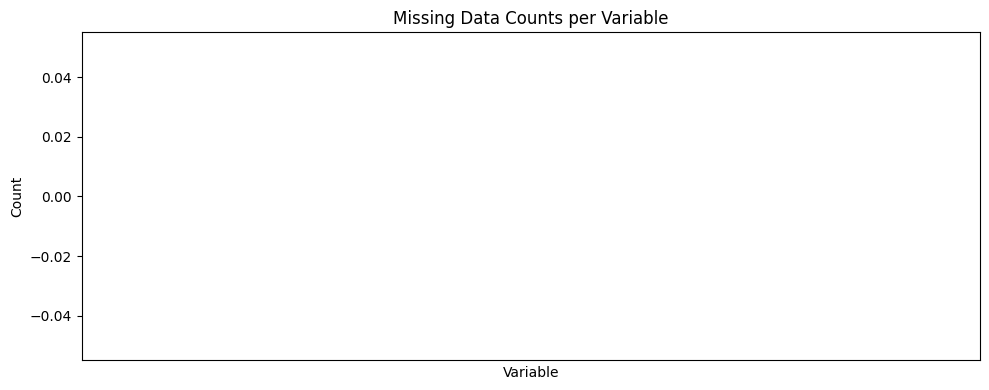

In [22]:
eda_helper_functions.plot_missing_info(train)

## 5.High-level analysis of outliers

In [24]:
forest=IsolationForest(n_estimators=10,random_state=42)

In [27]:
(
    train
    .assign(outlier=forest.fit_predict(train
                                       .drop(columns="price")
                                       .select_dtypes(include="number")
                                      )
           )
    .query("outlier==-1")
    #.duration
    #.describe()
)

count     248.000000
mean      851.068548
std       639.594671
min        75.000000
25%       140.000000
50%      1005.000000
75%      1426.250000
max      2295.000000
Name: duration, dtype: float64

## 6.Pair Plots

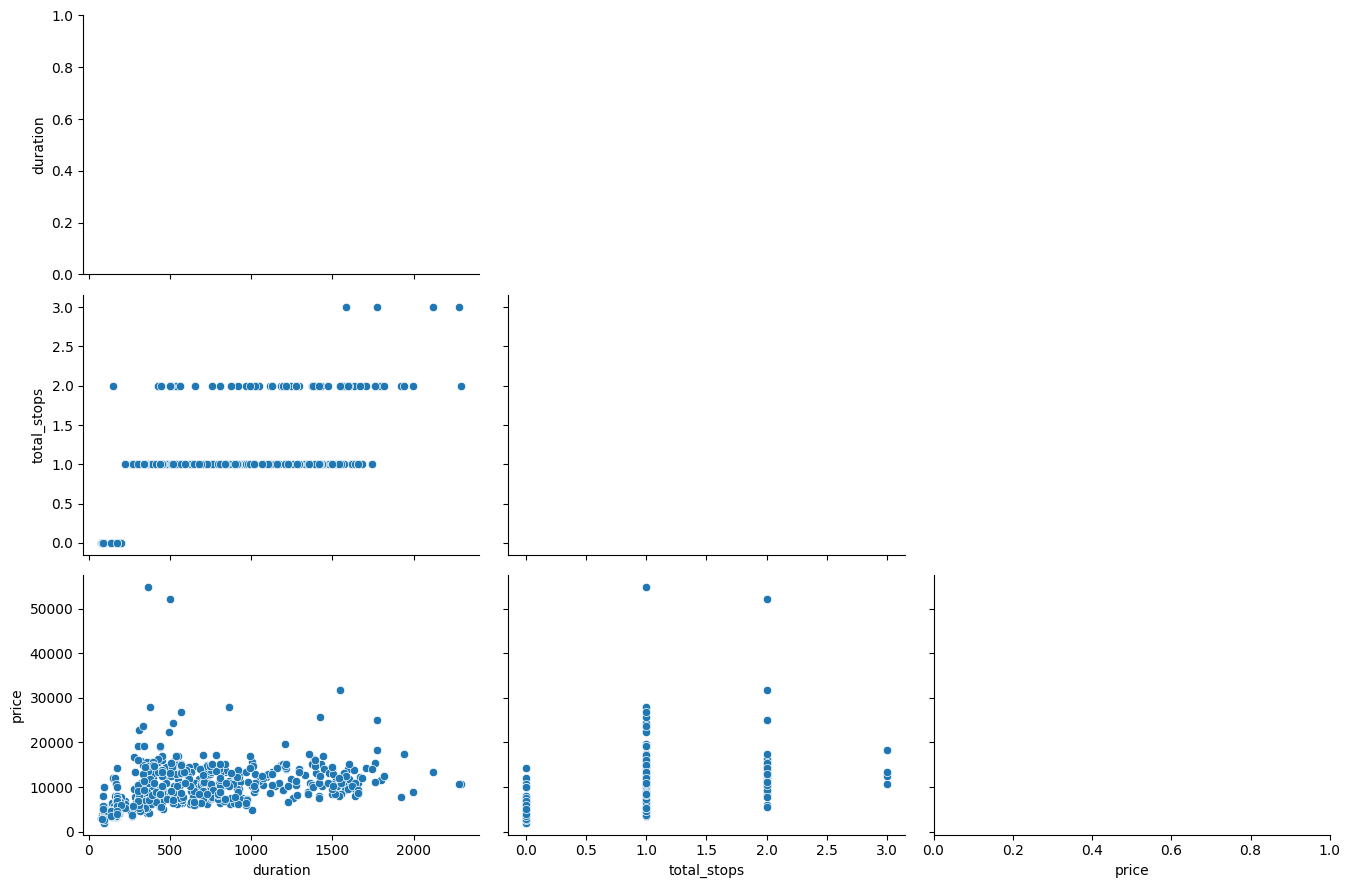

In [28]:
eda_helper_functions.pair_plots(train)

## 7.Correlation Analysis

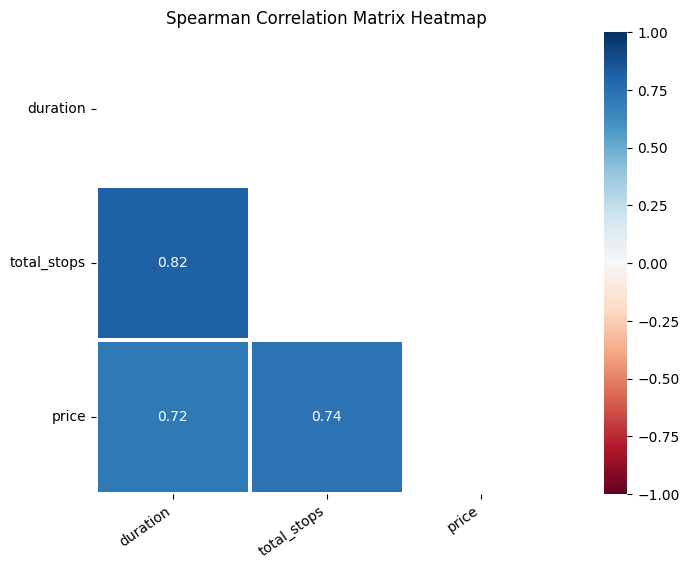

In [29]:
eda_helper_functions.correlation_heatmap(train)

In [30]:
train.corr(method="spearman",numeric_only=True)

,duration,total_stops,price
duration,1.000000,0.816963,0.717075
total_stops,0.816963,1.000000,0.739213
price,0.717075,0.739213,1.000000


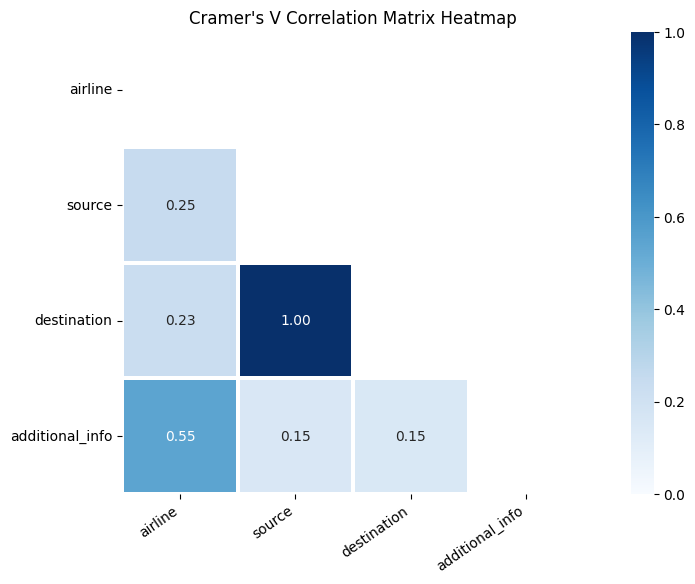

In [31]:
eda_helper_functions.cramersV_heatmap(train)

## 8.Detailed Analysis

In [32]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 airline

In [33]:
train.airline

0      Jet Airways
1        Air India
2           Indigo
3           Indigo
4      Jet Airways
          ...     
635         Indigo
636        Vistara
637       Spicejet
638         Indigo
639    Jet Airways
Name: airline, Length: 640, dtype: object

In [34]:
eda_helper_functions.cat_summary(train,"airline")

0      Jet Airways
1        Air India
2           Indigo
3           Indigo
4      Jet Airways
          ...     
635         Indigo
636        Vistara
637       Spicejet
638         Indigo
639    Jet Airways
Name: airline, Length: 640, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,8
top,Jet Airways
freq,231


,count,percentage
category,,
Jet Airways,231,0.360938
Indigo,132,0.206250
Air India,101,0.157812
Multiple Carriers,66,0.103125
Spicejet,42,0.065625
Vistara,34,0.053125
Air Asia,24,0.037500
Goair,10,0.015625


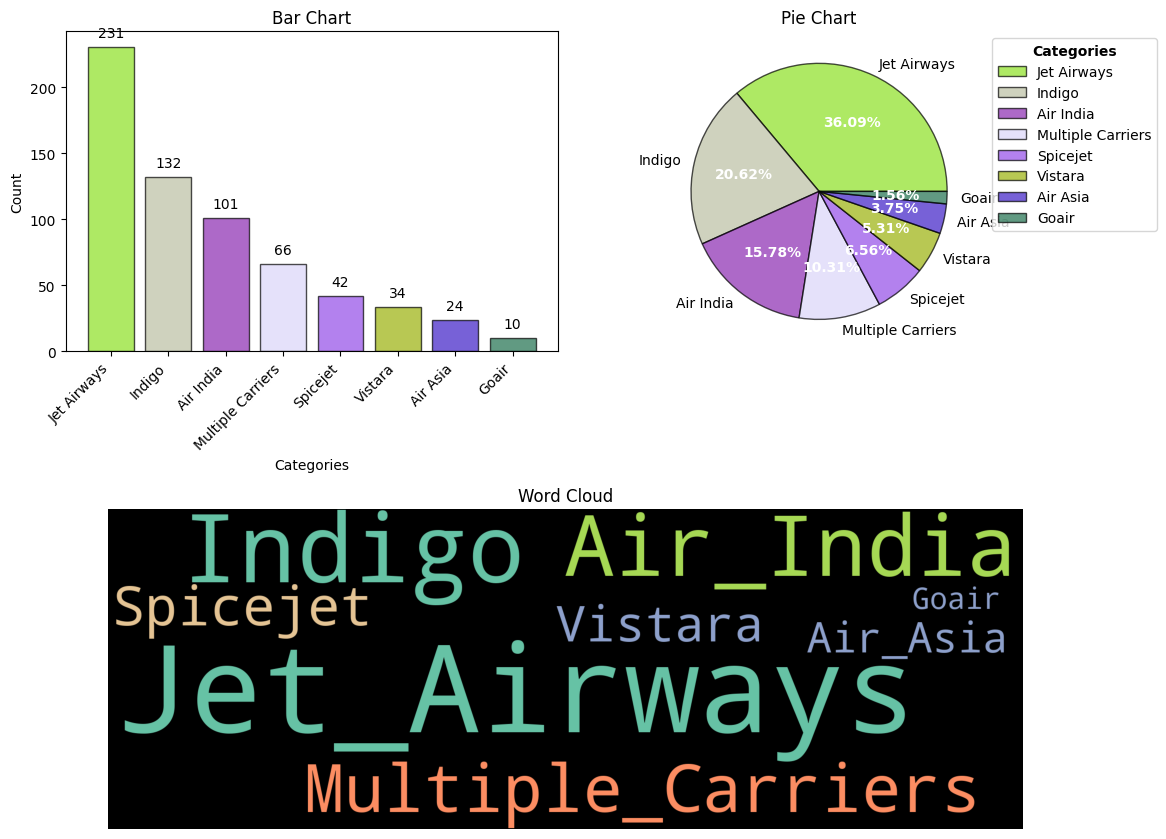

In [35]:
eda_helper_functions.cat_univar_plots(train,"airline")

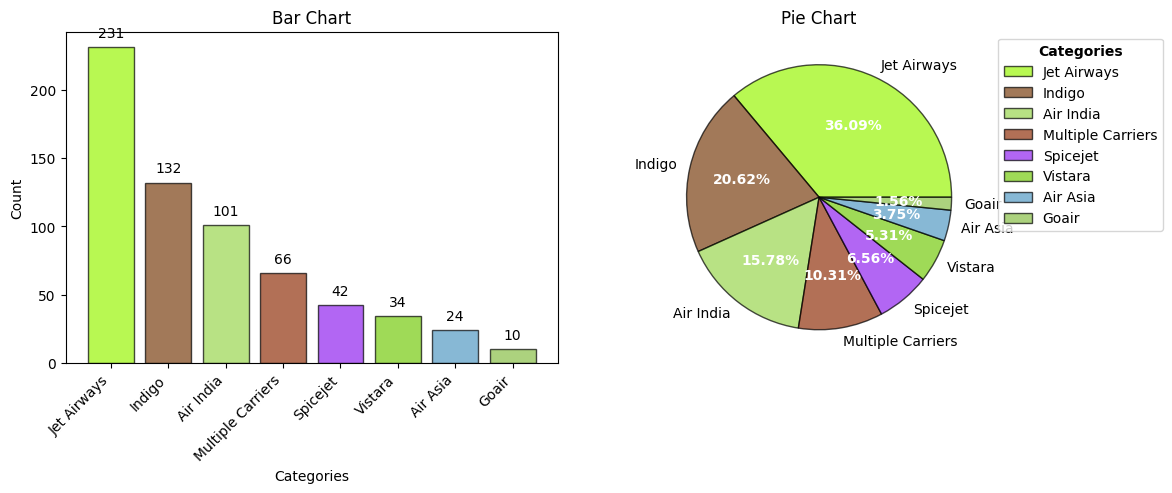

In [36]:
eda_helper_functions.cat_univar_plots(train,"airline",show_wordcloud=False)

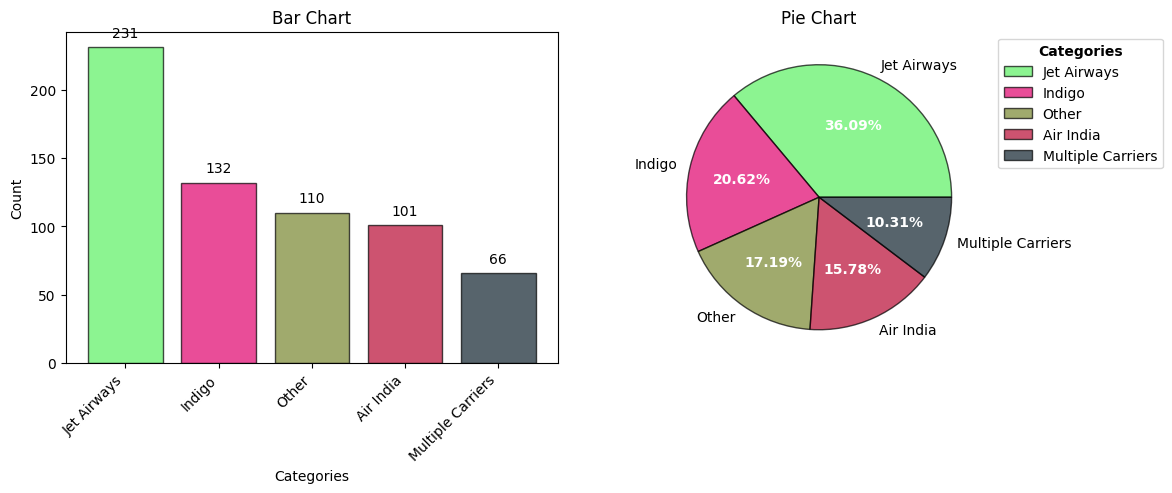

In [37]:
eda_helper_functions.cat_univar_plots(train,"airline",show_wordcloud=False,k=4)

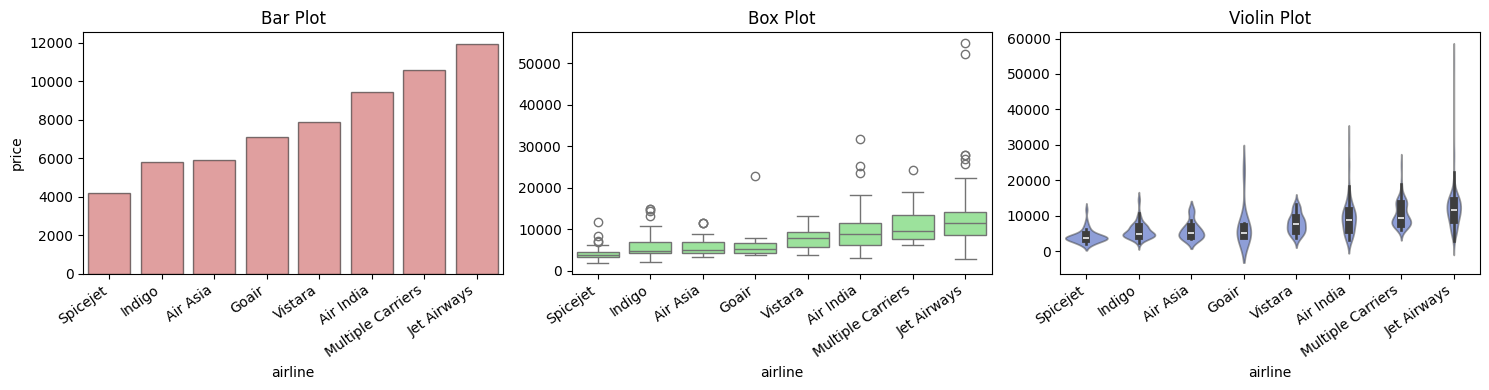

In [38]:
eda_helper_functions.num_cat_bivar_plots(
    data=train,
    num_var="price",
    cat_var="airline"
)

In [39]:
eda_helper_functions.num_cat_hyp_testing(train,"price","airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 36.29056163332928
- p-value              : 1.0424629004901291e-42
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 270.24944313172426
- p-value              : 1.3470676545192417e-54
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


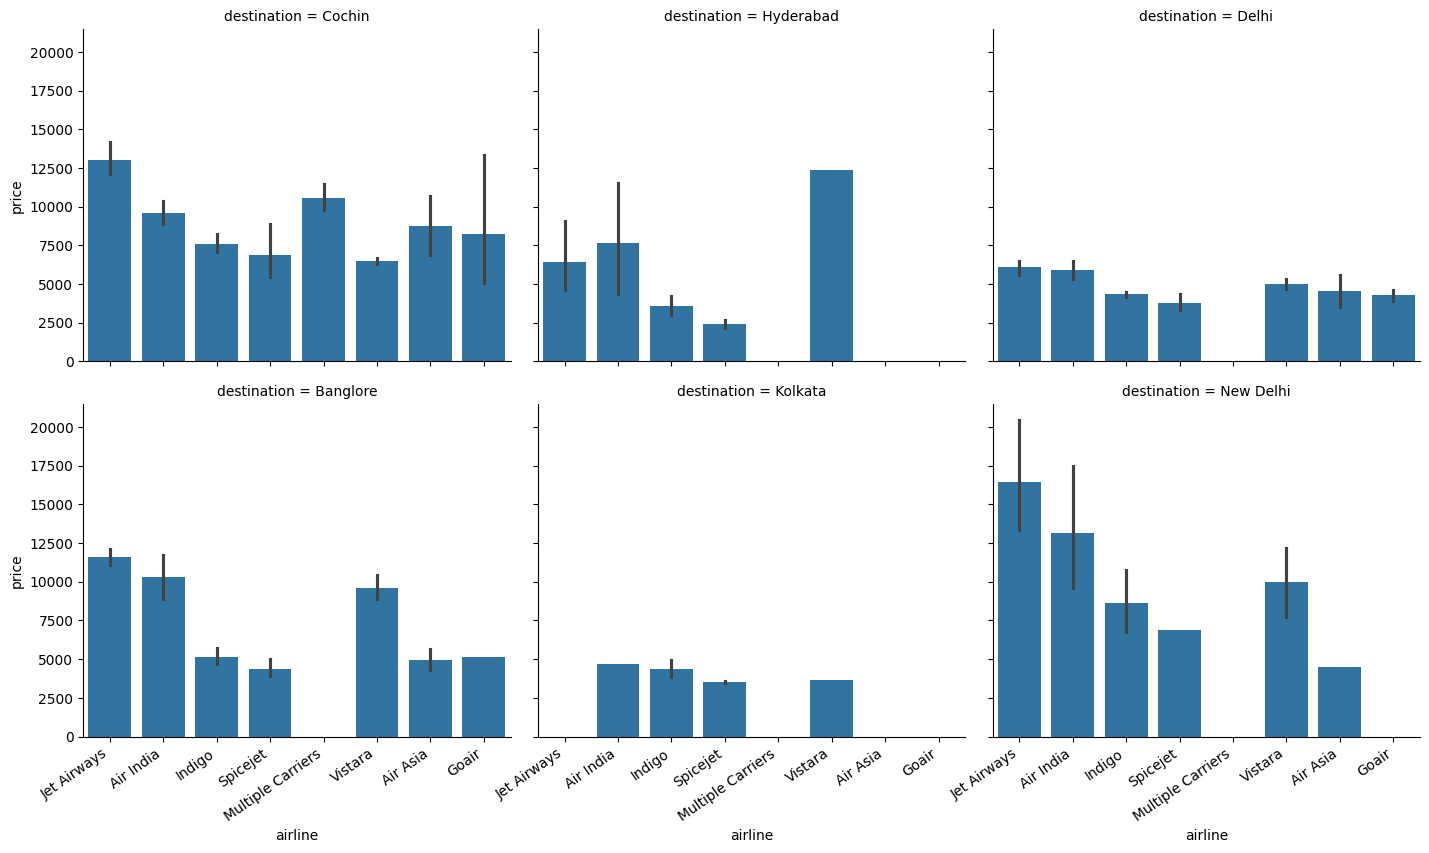

In [45]:
airline_grid=sns.FacetGrid(
    data=train,
    col="destination",
    col_wrap=3,
    height=4,
    aspect=1.2,
    sharey=True
)
airline_grid.map(sns.barplot,"airline","price",order=train.airline.unique())
for ax in airline_grid.axes[3:]:
    eda_helper_functions.rotate_xlabels(ax)

### 8.2 date_of_journey

In [46]:
train.date_of_journey

0     2019-03-09
1     2019-03-06
2     2019-06-09
3     2019-05-01
4     2019-06-03
         ...    
635   2019-06-01
636   2019-05-01
637   2019-05-18
638   2019-06-15
639   2019-06-18
Name: date_of_journey, Length: 640, dtype: datetime64[ns]

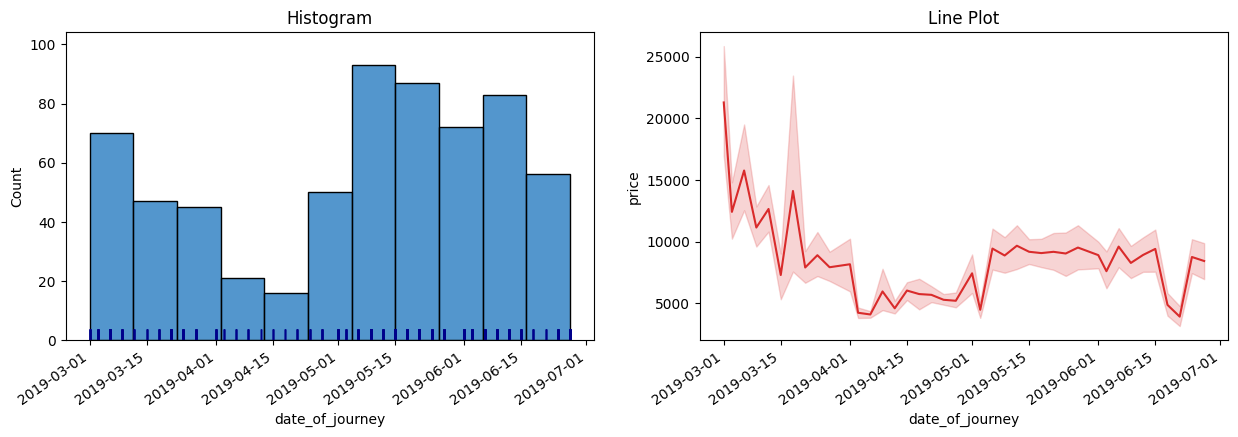

In [47]:
eda_helper_functions.dt_univar_plots(
    data=train,
    var="date_of_journey",
    target="price"
)

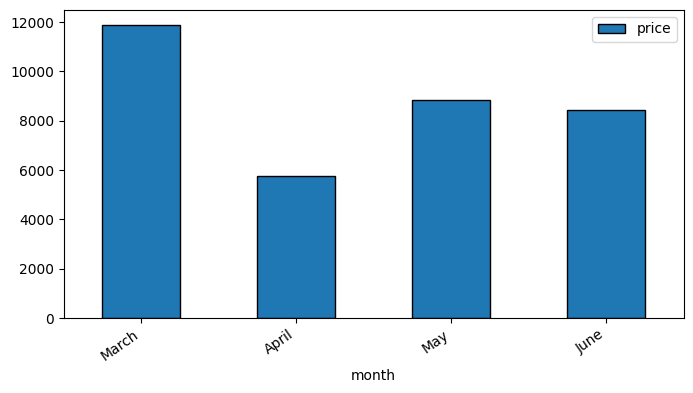

In [60]:
(
     train
    .groupby(pd.Grouper(key="date_of_journey",freq='M'))
    .price.mean()
    .to_frame()
    .set_axis(["March","April","May","June"],axis=0)
    .rename_axis(index="month")
    .plot(kind="bar",figsize=(8,4),edgecolor="black")
)
ax=plt.gca()
eda_helper_functions.rotate_xlabels(ax)

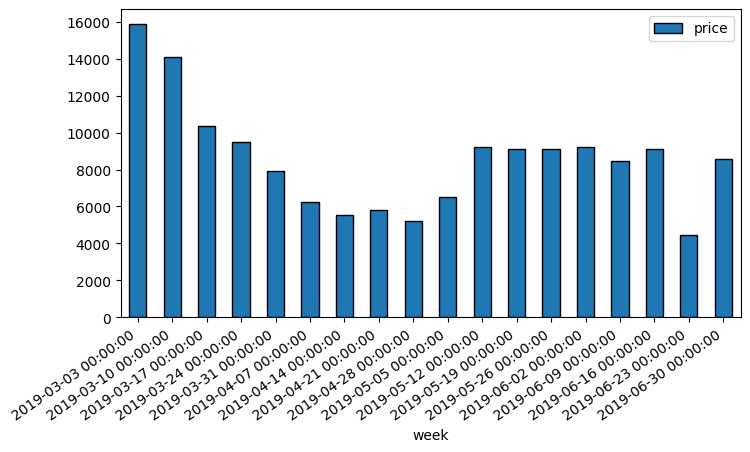

In [59]:
(
     train
    .groupby(pd.Grouper(key="date_of_journey",freq='W'))
    .price.mean()
    .to_frame()
    .rename_axis(index="week")
    .plot(kind="bar",figsize=(8,4),edgecolor="black")
)
ax=plt.gca()
eda_helper_functions.rotate_xlabels(ax)

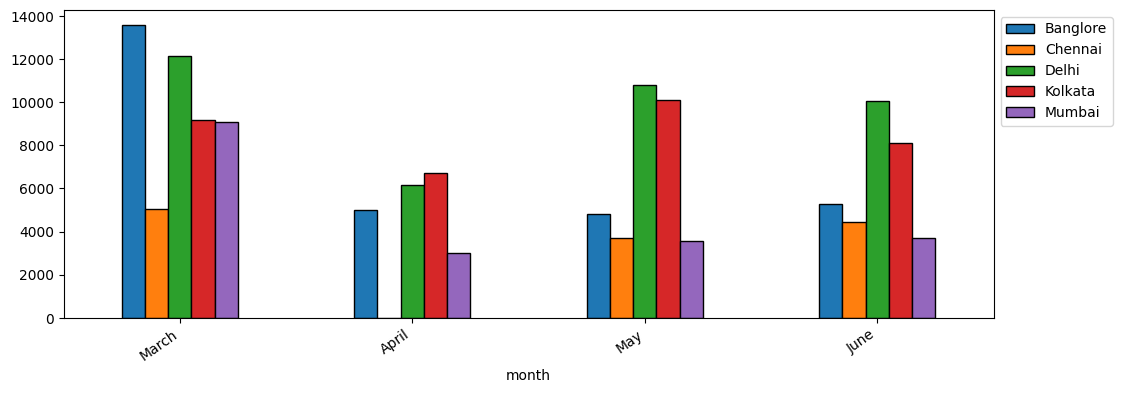

In [67]:
(
    train
    .groupby([pd.Grouper(key="date_of_journey",freq="M"),"source"])
    .price.mean()
    .unstack(fill_value=0)
    .set_axis(["March","April","May","June"],axis=0)
    .rename_axis(index="month")
    .plot(kind="bar",figsize=(12,4),edgecolor="black")
)
ax=plt.gca()
ax.legend(
    loc="upper left",
    bbox_to_anchor=(1,1)
)
eda_helper_functions.rotate_xlabels(ax)

### 8.3 dep_time

In [68]:
train.dep_time

0     2026-01-14 19:45:00
1     2026-01-14 17:20:00
2     2026-01-14 11:25:00
3     2026-01-14 23:30:00
4     2026-01-14 17:30:00
              ...        
635   2026-01-14 14:25:00
636   2026-01-14 11:30:00
637   2026-01-14 08:20:00
638   2026-01-14 13:00:00
639   2026-01-14 02:55:00
Name: dep_time, Length: 640, dtype: datetime64[ns]

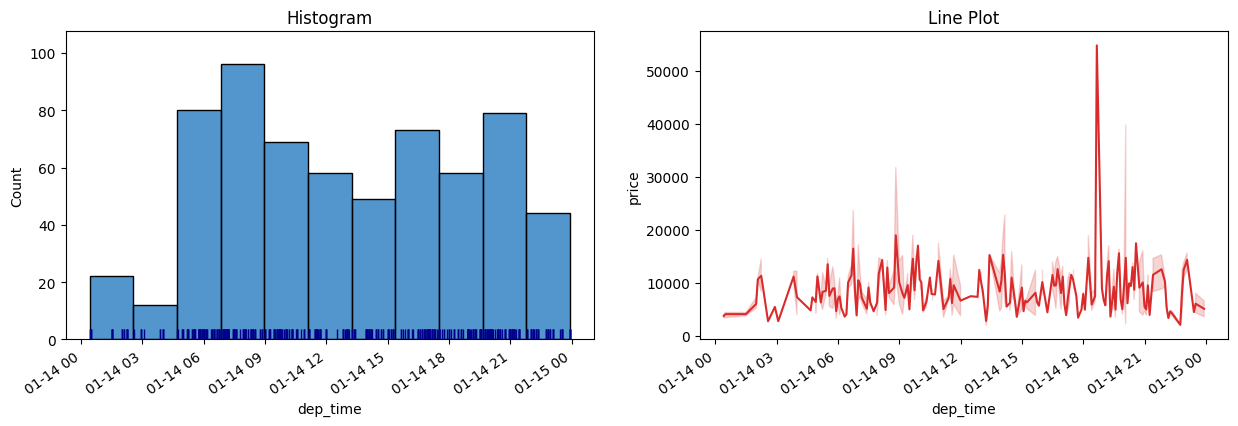

In [69]:
eda_helper_functions.dt_univar_plots(train,"dep_time","price")

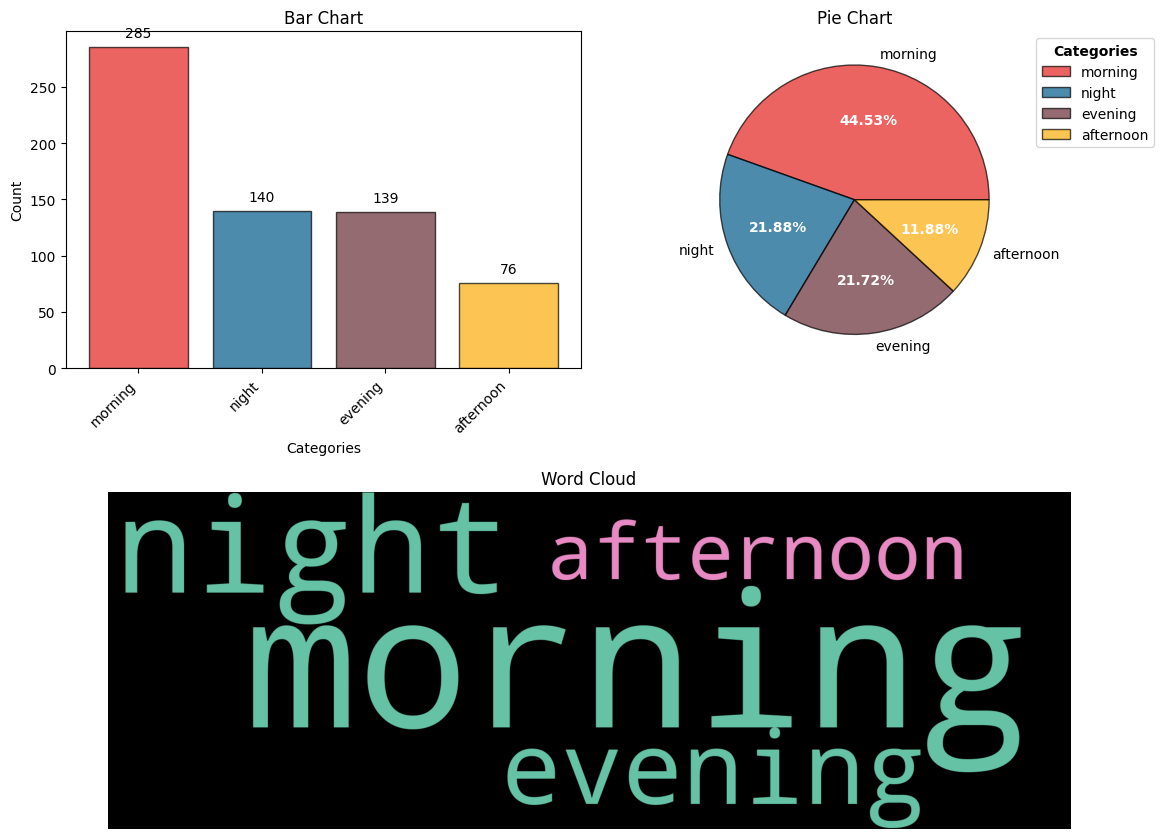

In [76]:
(
    train
    .assign(dep_time=lambda df_:(
        np.select([df_.dep_time.dt.hour.between(4,12,inclusive="left"),
                   df_.dep_time.dt.hour.between(12,16,inclusive="left"),
                   df_.dep_time.dt.hour.between(16,20,inclusive="left")],
                   ["morning","afternoon","evening"],
                    default="night")
    ))
    .pipe(eda_helper_functions.cat_univar_plots,"dep_time")

    
)

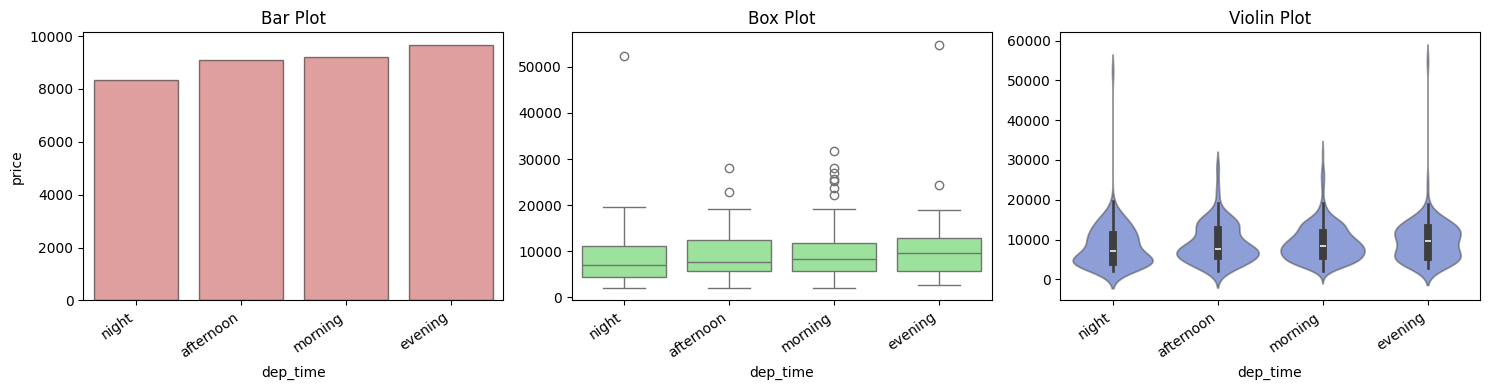

In [77]:
(
    train
    .assign(dep_time=lambda df_:(
        np.select([df_.dep_time.dt.hour.between(4,12,inclusive="left"),
                   df_.dep_time.dt.hour.between(12,16,inclusive="left"),
                   df_.dep_time.dt.hour.between(16,20,inclusive="left")],
                   ["morning","afternoon","evening"],
                    default="night")
    ))
    .pipe(eda_helper_functions.num_cat_bivar_plots,"price","dep_time")

    
)

### 8.4 duration

In [78]:
train.duration

0      1385
1       150
2       575
3       170
4       655
       ... 
635     195
636     170
637     135
638     170
639      85
Name: duration, Length: 640, dtype: int64

In [79]:
eda_helper_functions.num_summary(train,"duration")

0      1385
1       150
2       575
3       170
4       655
       ... 
635     195
636     170
637     135
638     170
639      85
Name: duration, Length: 640, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,value
percentile,
0,75.00
5,90.00
10,145.00
25,170.00
50,450.00
75,848.75
90,1420.50
95,1585.50
99,1812.20


,value
mean,598.906250
trimmed mean (5%),563.211806
trimmed mean (10%),531.357422
median,450.000000


,value
var,239178.379304
std,489.058667
IQR,678.750000
mad,285.000000
coef_variance,0.816586


,value
skewness,1.008173
kurtosis,0.089945


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 1.1895651190928575e-22
Test Statistic       : 0.8699727467827032
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.782
Test Statistic       : 28.084018855282693
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


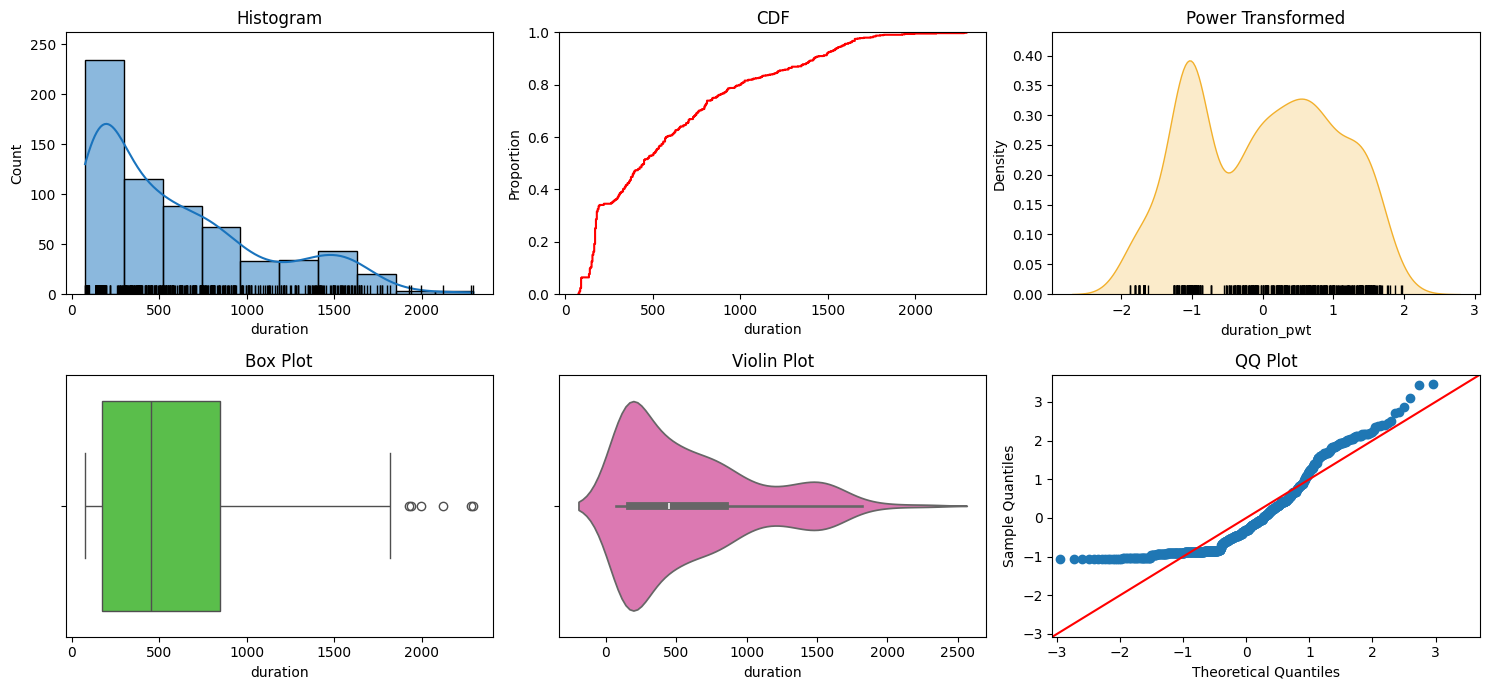

In [80]:
eda_helper_functions.num_univar_plots(train,"duration")

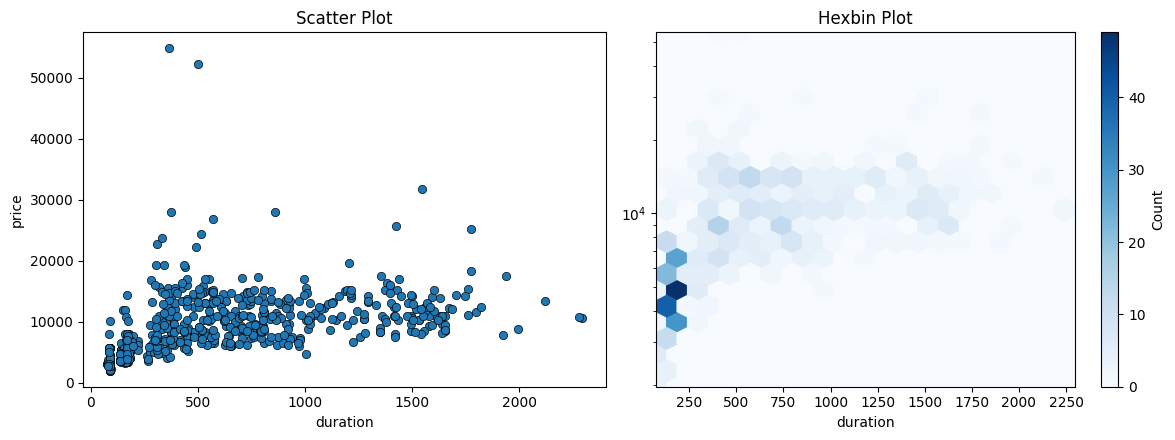

In [85]:
eda_helper_functions.num_bivar_plots(
    train,
    "duration",
    "price",
    hexbin_kwargs=dict(
        yscale="log",
        gridsize=20,
        cmap="Blues")
)

In [86]:
eda_helper_functions.num_num_hyp_testing(train,"price","duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.4569966874050442
- p-value              : 2.410935237899793e-34
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.7170746232762463
- p-value              : 4.209578272592852e-102
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


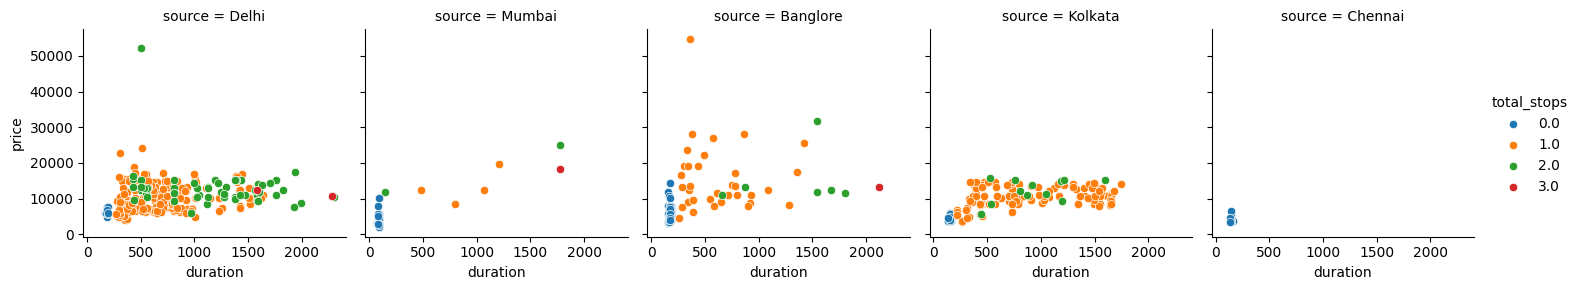

In [90]:
duration_grid=sns.FacetGrid(
    data=train,
    col="source",
    hue="total_stops",
    sharey=True
)
duration_grid.map(sns.scatterplot,"duration","price")
duration_grid.add_legend()

In [102]:
eda_helper_functions.get_iqr_outliers(train,"duration")

Lower Limit : -848.125
Upper Limit : 1866.875


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
534,Jet Airways,2019-03-21,Delhi,Cochin,2026-01-16 10:45:00,2026-01-16 18:50:00,1925,2.0,In-flight meal not included,7791
616,Air India,2019-03-09,Delhi,Cochin,2026-01-16 10:55:00,2026-01-16 19:15:00,1940,2.0,No Info,17476
453,Jet Airways,2019-03-21,Delhi,Cochin,2026-01-16 19:10:00,2026-01-16 04:25:00,1995,2.0,In-flight meal not included,8834
465,Air India,2019-03-12,Banglore,New Delhi,2026-01-16 06:45:00,2026-01-16 18:05:00,2120,3.0,No Info,13387
535,Air India,2019-06-27,Delhi,Cochin,2026-01-16 05:15:00,2026-01-16 19:15:00,2280,3.0,No Info,10703
393,Air India,2019-03-09,Delhi,Cochin,2026-01-16 05:00:00,2026-01-16 19:15:00,2295,2.0,No Info,10598


## 9.Automated EDA

In [93]:
!pip install ydata-profiling

Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [94]:
from ydata_profiling import ProfileReport

In [95]:
report=ProfileReport(train)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]






00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.33it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [96]:
report.to_file(output_file="output.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]